# Fixed Wound Infection Detection Pipeline

This notebook implements the corrected training pipeline using modularized components.
It relies on `pipeline_utils.py` and `training_engine.py`.

In [1]:
import sys
import os
from pathlib import Path

# Ensure local modules can be imported
sys.path.append(os.getcwd())

import torch
import torch.optim as optim

# Import custom modules
from pipeline_utils import (
    set_seed, 
    get_device, 
    create_dataset, 
    make_dataloaders, 
    verify_dataset_sample
)
from training_engine import (
    build_model, 
    train_one_epoch, 
    validate_one_epoch, 
    evaluate_metrics, 
    save_checkpoint
)

print("Modules imported successfully.")

Modules imported successfully.


## 1. Configuration

Set paths and hyperparameters here.

In [2]:
# Configuration
CONFIG = {
    "data_root": "../../data",  # Root data directory where images are stored (task_0/data/, etc.)
    "ann_file_train": "../data/splits/train.json",  # Annotation files are in notebooks/data/
    "ann_file_val": "../data/splits/val.json",
    # Fallback if splits don't exist, use main annotation file for both (and filter manually if needed)
    "ann_file_full": "../data/annotations.json",
    
    "output_dir": "checkpoints_fixed",
    "seed": 42,
    "batch_size": 4,
    "num_workers": 0,  # Set to 0 for Windows compatibility/debugging
    "epochs": 50,  # Increased from 20 to 50 for better convergence
    "lr": 0.005,
    "device_prefer_cuda": True,
    "image_size": (512, 512)
}

# Ensure output dir exists
Path(CONFIG["output_dir"]).mkdir(exist_ok=True, parents=True)

## 2. Setup

In [3]:
set_seed(CONFIG["seed"])
device = get_device(CONFIG["device_prefer_cuda"])
print(f"Using device: {device}")

Using device: cpu


## 3. Data Preparation

In [4]:
# Resolve paths relative to notebook directory (notebooks/1.8.2025/)
# In Jupyter, cwd is typically the notebook directory
notebook_dir = Path.cwd()
if not (notebook_dir / "pipeline_utils.py").exists():
    # If not in the right directory, try to find it
    notebook_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()

# Resolve annotation file paths
train_ann = (notebook_dir / CONFIG["ann_file_train"]).resolve()
val_ann = (notebook_dir / CONFIG["ann_file_val"]).resolve()
ann_full = (notebook_dir / CONFIG["ann_file_full"]).resolve()
data_root = (notebook_dir / CONFIG["data_root"]).resolve()

# Check if splits exist, otherwise use full annotation file
if not train_ann.exists():
    print(f"Split file {train_ann} not found. Using full annotation file for both.")
    train_ann = ann_full
    val_ann = ann_full

print(f"Loading Train Data from: {train_ann}")
print(f"Data root: {data_root}")
train_dataset = create_dataset(
    root=str(data_root),
    annotation_file=str(train_ann),
    train=True,
    image_size=CONFIG["image_size"]
)

print(f"Loading Val Data from: {val_ann}")
val_dataset = create_dataset(
    root=str(data_root),
    annotation_file=str(val_ann),
    train=False,
    image_size=CONFIG["image_size"]
)

# Verify a sample
print("\nVerifying Dataset Sample:")
verify_dataset_sample(train_dataset)

# Create Loaders
train_loader, val_loader = make_dataloaders(
    train_dataset, 
    val_dataset, 
    batch_size=CONFIG["batch_size"],
    num_workers=CONFIG["num_workers"]
)
print(f"\nDataLoaders created. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Loading Train Data from: E:\GitHub\Wound-infection-detection-model\notebooks\data\splits\train.json
Data root: E:\GitHub\Wound-infection-detection-model\data
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Loading Val Data from: E:\GitHub\Wound-infection-detection-model\notebooks\data\splits\val.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

Verifying Dataset Sample:
Dataset length: 79
Sample 0:
  Image shape: torch.Size([3, 512, 512])
  Target keys: dict_keys(['image_id', 'boxes', 'labels', 'masks', 'area', 'iscrowd'])
  Boxes shape: torch.Size([3, 4])
  Masks shape: torch.Size([3, 512, 512])
  Labels: tensor([3, 8, 0])

DataLoaders created. Train batches: 20, Val batches: 4


## 4. Model Setup

In [5]:
# Determine number of classes
# COCO categories + 1 for background
if hasattr(train_dataset, 'coco_json'):
    # Use coco_json dict for accessing categories
    num_classes = len(train_dataset.coco_json['categories']) + 1
elif hasattr(train_dataset, 'coco'):
    # Handle COCO API object or dict
    if isinstance(train_dataset.coco, dict):
        num_classes = len(train_dataset.coco['categories']) + 1
    else:
        # COCO API object
        num_classes = len(train_dataset.coco.loadCats(train_dataset.coco.getCatIds())) + 1
else:
    # Fallback if accessed via subset
    base_dataset = train_dataset.dataset if hasattr(train_dataset, 'dataset') else train_dataset
    if hasattr(base_dataset, 'coco_json'):
        num_classes = len(base_dataset.coco_json['categories']) + 1
    else:
        num_classes = len(base_dataset.coco['categories']) + 1

print(f"Number of classes (including background): {num_classes}")

model = build_model(num_classes=num_classes)
model.to(device)

# Optimizer & Scheduler
# NOTE: Current settings (lr=0.005, 20 epochs) may be suboptimal for Mask R-CNN.
# For better recall, consider:
#   - Lower LR: 0.001 or 0.0005
#   - More epochs: 50+
#   - CosineAnnealingLR instead of StepLR
#   - See INFERENCE_GUIDE.md for detailed recommendations
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=CONFIG["lr"], momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Number of classes (including background): 17


## 5. Training Loop

In [6]:
best_metric = 0.0
num_epochs = CONFIG["epochs"]

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Train
    train_stats = train_one_epoch(
        model, 
        optimizer, 
        train_loader, 
        device, 
        epoch
    )
    
    # Validation Loss (with prediction tracking every 5 epochs)
    track_preds = (epoch % 5 == 0)  # Track predictions every 5 epochs to monitor scores
    val_stats = validate_one_epoch(
        model, 
        val_loader, 
        device,
        track_predictions=track_preds
    )
    
    # Print prediction statistics if tracked
    if track_preds and 'pred_mean_score' in val_stats:
        print(f"  Prediction stats: mean={val_stats.get('pred_mean_score', 0):.3f}, "
              f"at 0.3={val_stats.get('pred_at_thresh_0.3', 0)}, "
              f"at 0.5={val_stats.get('pred_at_thresh_0.5', 0)}")
    
    print(f"Epoch [{epoch}] Train Loss: {train_stats['total_loss']:.4f} | Val Loss: {val_stats['total_loss']:.4f}")
    
    # Update Scheduler
    lr_scheduler.step()
    
    # Evaluation Metrics
    # Run every few epochs to save time, or every epoch
    metrics = evaluate_metrics(model, val_loader, device)
    
    # Checkpoint Strategy - Clear progress condition
    # Priority: combined_AP50 > bbox_AP50 > f1
    # This determines when we save "best.pt"
    current_metric = None
    metric_name = None
    
    if "combined_AP50" in metrics:
        current_metric = metrics["combined_AP50"]
        metric_name = "combined_AP50 (bbox + segm)"
    elif "bbox_AP50" in metrics:
        current_metric = metrics["bbox_AP50"]
        metric_name = "bbox_AP50"
    elif "f1" in metrics:
        current_metric = metrics["f1"]
        metric_name = "f1"
    else:
        current_metric = 0.0
        metric_name = "unknown"
    
    # Check if this is the best model so far
    is_best = current_metric > best_metric
    
    # Print clear progress information
    print(f"\n{'='*60}")
    print(f"Epoch {epoch} Evaluation Results:")
    print(f"{'='*60}")
    print(f"Current {metric_name}: {current_metric:.4f}")
    print(f"Previous best: {best_metric:.4f}")
    
    if is_best:
        improvement = current_metric - best_metric
        best_metric = current_metric
        print(f"✓ IMPROVEMENT! (+{improvement:.4f})")
        print(f"  → Saving as best.pt (new best {metric_name}: {best_metric:.4f})")
    else:
        gap = best_metric - current_metric
        print(f"✗ No improvement (gap: {gap:.4f})")
        print(f"  → Keeping previous best.pt")
    print(f"{'='*60}\n")
    
    # Save checkpoint with proper state dict keys
    save_checkpoint(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": lr_scheduler.state_dict(),
            "epoch": epoch,
            "best_metric": best_metric,
            "best_metric_name": metric_name,
            "current_metric": current_metric,
            "config": str(CONFIG)
        },
        CONFIG["output_dir"],
        filename="last.pt",
        is_best=is_best
    )

print("Training Complete.")

Starting training for 50 epochs...
Epoch: [0] [0/20] Loss: 5.2165
Epoch: [0] [10/20] Loss: 3.8091
  Prediction stats: mean=0.059, at 0.3=0, at 0.5=0
Epoch [0] Train Loss: 3.6672 | Val Loss: 2.6212
Using COCO evaluator...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Avera

## 6. Test and Evaluate Model

After training, load the best model and test it on validation data.


In [16]:
# Load the best model checkpoint
from pathlib import Path
import importlib
import training_engine
# Force reload to get latest code (fixes PyTorch 2.6+ checkpoint loading)
importlib.reload(training_engine)
from training_engine import load_checkpoint, build_model
import torch
import numpy as np

# Fix for PyTorch 2.6+ - add numpy scalar to safe globals before loading
try:
    numpy_scalar = np._core.multiarray.scalar
except AttributeError:
    try:
        numpy_scalar = np.core.multiarray.scalar
    except AttributeError:
        numpy_scalar = None

if numpy_scalar is not None and hasattr(torch.serialization, 'add_safe_globals'):
    try:
        torch.serialization.add_safe_globals([numpy_scalar])
    except Exception:
        pass

# Get output directory from CONFIG if available, otherwise use default
if 'CONFIG' in globals():
    output_dir = CONFIG["output_dir"]
else:
    # Try to get from checkpoint or use default
    output_dir = "checkpoints_fixed"
    print(f"CONFIG not found, using default output_dir: {output_dir}")

# Get device
if 'device' in globals():
    device_to_use = device
else:
    from pipeline_utils import get_device
    device_to_use = get_device()
    print(f"Device not found in globals, using: {device_to_use}")

checkpoint_path = Path(output_dir) / "best.pt"
if not checkpoint_path.exists():
    # Fallback to last checkpoint if best doesn't exist
    checkpoint_path = Path(output_dir) / "last.pt"
    print(f"Best checkpoint not found, using last checkpoint: {checkpoint_path}")

# Load or create model
if checkpoint_path.exists():
    # Get num_classes - try multiple sources
    num_classes = None
    if 'model' in globals():
        # Model exists, infer num_classes from it
        try:
            # Get num_classes from model's box predictor
            num_classes = model.roi_heads.box_predictor.cls_score.out_features
        except:
            pass
    
    if num_classes is None:
        # Try to get from dataset if available
        if 'train_dataset' in globals():
            try:
                if hasattr(train_dataset, 'coco_json'):
                    num_classes = len(train_dataset.coco_json['categories']) + 1
                elif hasattr(train_dataset, 'coco'):
                    if isinstance(train_dataset.coco, dict):
                        num_classes = len(train_dataset.coco['categories']) + 1
            except:
                pass
    
    if num_classes is None:
        # Default fallback
        num_classes = 17
        print(f"Warning: Could not determine num_classes, using default: {num_classes}")
    
    # Create model if not exists
    if 'model' not in globals():
        print(f"Creating model with {num_classes} classes...")
        model = build_model(num_classes=num_classes)
        model.to(device_to_use)
    
    # Load checkpoint
    checkpoint = load_checkpoint(model, str(checkpoint_path))
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"Best metric: {checkpoint.get('best_metric', 'unknown'):.4f}")
else:
    print("No checkpoint found.")
    if 'model' not in globals():
        print("Model not found. Please run training cells first or provide a checkpoint.")
        raise NameError("Model not defined and no checkpoint found. Please run training cells first.")
    else:
        print("Using current model state.")


Best checkpoint not found, using last checkpoint: checkpoints_fixed\last.pt
Loaded checkpoint from epoch 49
Best metric: 0.0000


In [17]:
# Final evaluation on validation set
from pipeline_utils import create_dataset, make_dataloaders
from training_engine import evaluate_metrics
from pathlib import Path

# Check if required variables exist and create if needed
if 'model' not in globals():
    raise NameError("Model not defined. Please run the checkpoint loading cell (Cell 13) first.")

if 'device' not in globals():
    from pipeline_utils import get_device
    device = get_device()
    print(f"Device not found, using: {device}")

# Create val_loader if not exists
if 'val_loader' not in globals():
    print("Validation loader not found. Creating from dataset...")
    
    # Get paths
    if 'CONFIG' in globals():
        data_root = CONFIG["data_root"]
        val_ann = CONFIG.get("ann_file_val", CONFIG.get("ann_file_full", "../data/annotations.json"))
        batch_size = CONFIG.get("batch_size", 4)
        num_workers = CONFIG.get("num_workers", 0)
    else:
        # Use defaults
        notebook_dir = Path.cwd()
        data_root = str((notebook_dir / "../../data").resolve())
        val_ann = str((notebook_dir / "../data/splits/val.json").resolve())
        if not Path(val_ann).exists():
            val_ann = str((notebook_dir / "../data/annotations.json").resolve())
        batch_size = 4
        num_workers = 0
        print(f"Using default paths: data_root={data_root}, val_ann={val_ann}")
    
    # Create validation dataset and loader
    try:
        val_dataset = create_dataset(
            root=data_root,
            annotation_file=val_ann,
            train=False,
            image_size=(512, 512)
        )
        # Create a dummy train dataset for make_dataloaders
        train_dataset_dummy = create_dataset(
            root=data_root,
            annotation_file=val_ann,  # Use same file for dummy
            train=True,
            image_size=(512, 512)
        )
        _, val_loader = make_dataloaders(
            train_dataset_dummy,
            val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle_train=False
        )
        print(f"Created validation loader with {len(val_loader)} batches")
    except Exception as e:
        print(f"Error creating validation loader: {e}")
        raise NameError(f"Could not create validation loader. Please run data preparation cells first. Error: {e}")

print("Running final evaluation on validation set...")
final_metrics = evaluate_metrics(model, val_loader, device)

print("\n" + "="*60)
print("Final Evaluation Metrics")
print("="*60)
for key, value in final_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")
print("="*60)


Running final evaluation on validation set...
Using COCO evaluator...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.0


Running inference with confidence threshold: 0.3
  Image 1: 0 detections (from 73 raw)
  Image 2: 0 detections (from 25 raw)
  Image 3: 0 detections (from 25 raw)
  Image 4: 0 detections (from 13 raw)


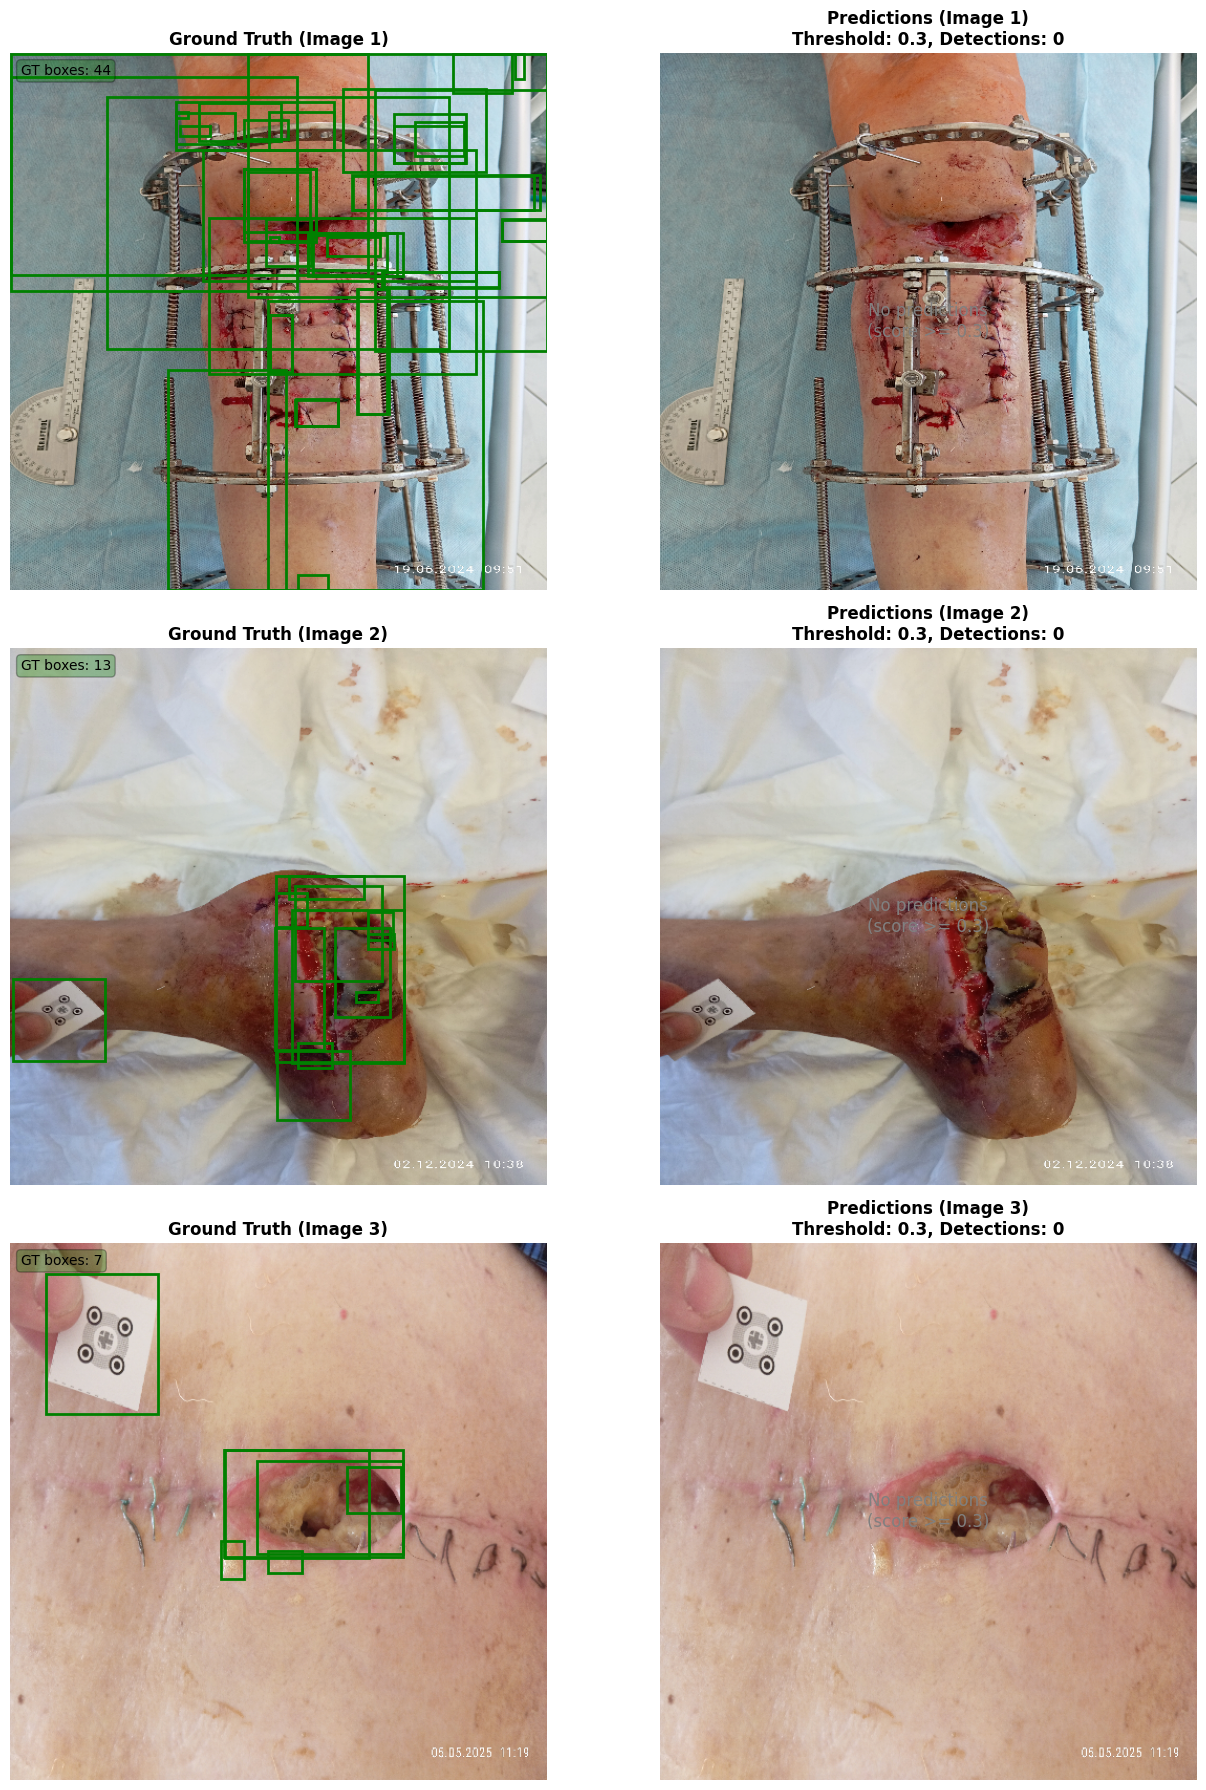


Visualization Summary (Threshold: 0.3)
Green boxes: Ground truth
Red boxes: High confidence (score >= 0.7)
Orange boxes: Medium confidence (0.5 <= score < 0.7)
Yellow boxes: Low confidence (0.3 <= score < 0.5)

Tip: Lower CONF_THRESH (e.g., 0.25) to see more predictions and improve recall.


In [18]:
# Test inference on a few sample images with configurable confidence threshold
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image
import numpy as np
from training_engine import run_inference

# Configuration: Confidence threshold (adjustable)
CONF_THRESH = 0.3  # Lower threshold to see more predictions (try 0.25, 0.3, 0.5)

# Check if required variables exist
if 'model' not in globals():
    raise NameError("Model not defined. Please run the checkpoint loading cell (Cell 13) first.")

if 'device' not in globals():
    from pipeline_utils import get_device
    device = get_device()

# Use val_loader from previous cell if available, otherwise create it
if 'val_loader' not in globals():
    print("Validation loader not found. Creating new one...")
    from pipeline_utils import create_dataset, make_dataloaders
    from pathlib import Path
    
    if 'CONFIG' in globals():
        data_root = CONFIG["data_root"]
        val_ann = CONFIG.get("ann_file_val", CONFIG.get("ann_file_full", "../data/annotations.json"))
        batch_size = CONFIG.get("batch_size", 4)
        num_workers = CONFIG.get("num_workers", 0)
    else:
        notebook_dir = Path.cwd()
        data_root = str((notebook_dir / "../../data").resolve())
        val_ann = str((notebook_dir / "../data/splits/val.json").resolve())
        if not Path(val_ann).exists():
            val_ann = str((notebook_dir / "../data/annotations.json").resolve())
        batch_size = 4
        num_workers = 0
        print(f"Using default paths: data_root={data_root}, val_ann={val_ann}")
    
    try:
        val_dataset = create_dataset(
            root=data_root,
            annotation_file=val_ann,
            train=False,
            image_size=(512, 512)
        )
        train_dataset_dummy = create_dataset(
            root=data_root,
            annotation_file=val_ann,
            train=True,
            image_size=(512, 512)
        )
        _, val_loader = make_dataloaders(
            train_dataset_dummy,
            val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle_train=False
        )
        print(f"Created validation loader with {len(val_loader)} batches")
    except Exception as e:
        print(f"Error creating validation loader: {e}")
        raise NameError(f"Could not create validation loader. Error: {e}")

# Get a batch from validation loader
sample_batch = next(iter(val_loader))
images, targets = sample_batch

# Run inference using the new inference function
print(f"\nRunning inference with confidence threshold: {CONF_THRESH}")
all_results = []
for idx, img_tensor in enumerate(images):
    result = run_inference(model, img_tensor, device, conf_thresh=CONF_THRESH)
    all_results.append(result)
    print(f"  Image {idx+1}: {result['num_detections']} detections (from {result['num_raw']} raw)")

# Visualize predictions (first 3 images)
num_show = min(3, len(images))
fig, axes = plt.subplots(num_show, 2, figsize=(14, 6 * num_show))

if num_show == 1:
    axes = axes.reshape(1, -1)

for idx in range(num_show):
    # Original image
    img = images[idx]
    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_vis = img * std + mean
    img_vis = torch.clamp(img_vis, 0, 1)
    img_pil = to_pil_image(img_vis)
    
    # Ground truth
    ax_gt = axes[idx, 0]
    ax_gt.imshow(img_pil)
    ax_gt.set_title(f"Ground Truth (Image {idx+1})", fontsize=12, weight='bold')
    ax_gt.axis('off')
    
    gt_boxes = targets[idx]['boxes']
    if len(gt_boxes) > 0:
        for box in gt_boxes:
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            if w > 0 and h > 0:  # Valid box
                rect = patches.Rectangle(
                    (x1, y1), w, h,
                    linewidth=2, edgecolor='green', facecolor='none'
                )
                ax_gt.add_patch(rect)
        ax_gt.text(0.02, 0.98, f"GT boxes: {len(gt_boxes)}", 
                   transform=ax_gt.transAxes,
                   ha='left', va='top', fontsize=10, 
                   bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
    else:
        ax_gt.text(0.5, 0.5, "No ground truth\nboxes", 
                  transform=ax_gt.transAxes,
                  ha='center', va='center', fontsize=12, color='gray')
    
    # Predictions
    ax_pred = axes[idx, 1]
    ax_pred.imshow(img_pil)
    result = all_results[idx]
    filtered = result['filtered']
    boxes = filtered['boxes']
    scores = filtered['scores']
    labels = filtered['labels']
    
    ax_pred.set_title(f"Predictions (Image {idx+1})\nThreshold: {CONF_THRESH}, Detections: {len(boxes)}", 
                     fontsize=12, weight='bold')
    ax_pred.axis('off')
    
    # Show predictions
    num_preds = 0
    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        if w > 0 and h > 0:  # Valid box
            # Color based on score
            if score >= 0.7:
                color = 'red'
            elif score >= 0.5:
                color = 'orange'
            else:
                color = 'yellow'
            
            rect = patches.Rectangle(
                (x1, y1), w, h,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax_pred.add_patch(rect)
            ax_pred.text(x1, max(0, y1-5), f"{score:.2f}", 
                        color=color, fontsize=8, weight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
            num_preds += 1
    
    if num_preds == 0:
        ax_pred.text(0.5, 0.5, f"No predictions\n(score >= {CONF_THRESH})", 
                    transform=ax_pred.transAxes,
                    ha='center', va='center', fontsize=12, color='gray')
    else:
        # Show raw stats
        raw_scores = result['raw']['scores']
        if len(raw_scores) > 0:
            ax_pred.text(0.02, 0.02, 
                        f"Raw: {result['num_raw']} | Filtered: {len(boxes)}\n"
                        f"Max score: {np.max(raw_scores):.3f}",
                        transform=ax_pred.transAxes,
                        ha='left', va='bottom', fontsize=9,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Visualization Summary (Threshold: {CONF_THRESH})")
print(f"{'='*60}")
print(f"Green boxes: Ground truth")
print(f"Red boxes: High confidence (score >= 0.7)")
print(f"Orange boxes: Medium confidence (0.5 <= score < 0.7)")
print(f"Yellow boxes: Low confidence ({CONF_THRESH} <= score < 0.5)")
print(f"\nTip: Lower CONF_THRESH (e.g., 0.25) to see more predictions and improve recall.")


## 7. Wound Area and Infection Analysis

Compute wound area (in cm²) and detect infection indicators using the reference marker.


In [19]:
# Wound area and infection analysis
from training_engine import run_wound_inference
from pathlib import Path

# Configuration: Adjust these based on your class IDs
# You need to know which class IDs correspond to:
WOUND_CLASS_IDS = [1, 2]  # Example: class 1 = wound, class 2 = wound region
INFECTION_CLASS_IDS = [3, 4, 5]  # Example: class 3 = necrosis, class 4 = hyperemia, class 5 = infection
MARKER_CLASS_ID = 6  # Example: class 6 = 3x3 cm reference marker
MARKER_SIZE_CM2 = 9.0  # 3x3 cm = 9 cm²

# Confidence threshold for inference
CONF_THRESH_WOUND = 0.3  # Lower threshold for wound detection

# Check if required variables exist
if 'model' not in globals():
    raise NameError("Model not defined. Please run the checkpoint loading cell (Cell 13) first.")
if 'device' not in globals():
    from pipeline_utils import get_device
    device = get_device()

# Get a sample image from validation set
if 'val_loader' not in globals():
    print("Creating validation loader...")
    from pipeline_utils import create_dataset, make_dataloaders
    from pathlib import Path
    
    if 'CONFIG' in globals():
        data_root = CONFIG["data_root"]
        val_ann = CONFIG.get("ann_file_val", CONFIG.get("ann_file_full", "../data/annotations.json"))
    else:
        notebook_dir = Path.cwd()
        data_root = str((notebook_dir / "../../data").resolve())
        val_ann = str((notebook_dir / "../data/splits/val.json").resolve())
        if not Path(val_ann).exists():
            val_ann = str((notebook_dir / "../data/annotations.json").resolve())
    
    val_dataset = create_dataset(root=data_root, annotation_file=val_ann, train=False, image_size=(512, 512))
    train_dataset_dummy = create_dataset(root=data_root, annotation_file=val_ann, train=True, image_size=(512, 512))
    _, val_loader = make_dataloaders(train_dataset_dummy, val_dataset, batch_size=1, num_workers=0, shuffle_train=False)

# Get first image from validation set
sample_batch = next(iter(val_loader))
sample_image = sample_batch[0][0]  # First image from first batch

# Run wound inference
print(f"Running wound inference with threshold: {CONF_THRESH_WOUND}")
print(f"Wound classes: {WOUND_CLASS_IDS}, Infection classes: {INFECTION_CLASS_IDS}, Marker class: {MARKER_CLASS_ID}")
print("-" * 60)

result = run_wound_inference(
    model=model,
    image=sample_image,
    device=device,
    conf_thresh=CONF_THRESH_WOUND,
    wound_class_ids=WOUND_CLASS_IDS,
    infection_class_ids=INFECTION_CLASS_IDS,
    marker_class_id=MARKER_CLASS_ID,
    marker_size_cm2=MARKER_SIZE_CM2
)

# Display results
print("\n" + "="*60)
print("Wound Analysis Results")
print("="*60)
print(f"Marker found: {result['marker_found']}")
if result['marker_found']:
    print(f"  Marker area (pixels): {result['marker_area_pixels']:.1f}")
    print(f"  Pixel to cm² ratio: {result['pixel_to_cm2_ratio']:.6f}")
else:
    print("  ⚠️  Marker not found - cannot compute wound area in cm²")

print(f"\nWound area (pixels): {result['wound_area_pixels']:.1f}")
print(f"Wound area ratio: {result['wound_area_ratio']:.4f} ({result['wound_area_ratio']*100:.2f}% of image)")

if result['wound_area_cm2'] is not None:
    print(f"Wound area (cm²): {result['wound_area_cm2']:.2f}")
else:
    print("Wound area (cm²): N/A (marker required)")

print(f"\nTotal detections: {result['num_detections']}")
print(f"  Raw detections: {result['raw_stats']['num_raw']}")
print(f"  Filtered (threshold {CONF_THRESH_WOUND}): {result['raw_stats']['num_filtered']}")

print(f"\nInfection indicators:")
if result['infection_flags']:
    for class_id, info in result['infection_flags'].items():
        status = "✓ DETECTED" if info['detected'] else "✗ Not detected"
        print(f"  Class {class_id}: {status}")
        if info['detected']:
            print(f"    - Count: {info['count']}")
            print(f"    - Max score: {info['max_score']:.3f}")
else:
    print("  No infection classes configured")

print("\nAll detections:")
for i, det in enumerate(result['detections'][:10]):  # Show first 10
    print(f"  {i+1}. Class {det['class_id']}, Score: {det['score']:.3f}, Has mask: {det['has_mask']}")

if len(result['detections']) > 10:
    print(f"  ... and {len(result['detections']) - 10} more")

print("="*60)


Running wound inference with threshold: 0.3
Wound classes: [1, 2], Infection classes: [3, 4, 5], Marker class: 6
------------------------------------------------------------

Wound Analysis Results
Marker found: False
  ⚠️  Marker not found - cannot compute wound area in cm²

Wound area (pixels): 0.0
Wound area ratio: 0.0000 (0.00% of image)
Wound area (cm²): N/A (marker required)

Total detections: 0
  Raw detections: 73
  Filtered (threshold 0.3): 0

Infection indicators:
  Class 3: ✗ Not detected
  Class 4: ✗ Not detected
  Class 5: ✗ Not detected

All detections:


In [22]:
# Summary statistics
print("\n" + "="*60)
print("Training Summary")
print("="*60)

# Get values from globals if available
if 'num_epochs' in globals():
    print(f"Total epochs trained: {num_epochs}")
if 'best_metric' in globals():
    print(f"Best metric achieved: {best_metric:.4f}")

if 'final_metrics' in globals():
    print(f"\nFinal validation metrics:")
    print("-" * 60)
    for key, value in final_metrics.items():
        if isinstance(value, float):
            print(f"  {key:20s}: {value:.4f}")

# Get output_dir
if 'CONFIG' in globals():
    output_dir = CONFIG['output_dir']
elif 'output_dir' in locals():
    pass  # Already defined
else:
    output_dir = "checkpoints_fixed"

print(f"\n{'='*60}")
print("Checkpoint Information")
print(f"{'='*60}")
print(f"Output directory: {output_dir}")
print(f"  ✓ Best model: {output_dir}/best.pt")
print(f"    → Saved when validation metric improved")
# Fix: cannot use conditional in format specifier, must compute value first
best_metric_val = best_metric if 'best_metric' in globals() else None
best_metric_str = f"{best_metric_val:.4f}" if best_metric_val is not None else 'N/A'
print(f"    → Best metric value: {best_metric_str}")
print(f"  ✓ Last model: {output_dir}/last.pt")
print(f"    → Saved every epoch")
final_epoch = num_epochs - 1 if 'num_epochs' in globals() else 'N/A'
print(f"    → Final epoch: {final_epoch}")

print(f"\nProgress Condition (when best.pt is saved):")
print(f"  - Metric priority: combined_AP50 > bbox_AP50 > f1")
print(f"  - Condition: current_metric > previous_best")
# Fix: cannot use conditional in format specifier, must compute value first
current_best_val = best_metric if 'best_metric' in globals() else None
current_best_str = f"{current_best_val:.4f}" if current_best_val is not None else 'N/A'
print(f"  - Current best: {current_best_str}")
print("="*60)



Training Summary
Total epochs trained: 50
Best metric achieved: 0.0000

Final validation metrics:
------------------------------------------------------------
  bbox_AP             : 0.0000
  bbox_AP50           : 0.0000
  bbox_AP75           : 0.0000
  segm_AP             : 0.0000
  segm_AP50           : 0.0000
  segm_AP75           : 0.0000
  combined_AP50       : 0.0000

Checkpoint Information
Output directory: checkpoints_fixed
  ✓ Best model: checkpoints_fixed/best.pt
    → Saved when validation metric improved
    → Best metric value: 0.0000
  ✓ Last model: checkpoints_fixed/last.pt
    → Saved every epoch
    → Final epoch: 49

Progress Condition (when best.pt is saved):
  - Metric priority: combined_AP50 > bbox_AP50 > f1
  - Condition: current_metric > previous_best
  - Current best: 0.0000
